# ***Presentación***

## **Tecnicatura Universitaria en Inteligencia Artificial**

### Trabajo Práctico - Minería de Datos

#### Support Vector Machines y Random Forest

---

**Equipo**:
- Revello Simon
- Giampaoli Fabio

**Fecha**: 24/11/2023

---

## ***Objetivo***


El objetivo de este trabajo practico es integrar los conocimientos adquiridos en las unidades 5 y 6
en un problema real asociado a la determinación del color de los granos de café mediante la
medición atributos característicos.

# ***Entorno***

En este bloque se importaran los modulos y conjuntos de datos inciales que seran de utilidad para el desarrollo de funcionalidades especificas de los problemas.

## Librerias

In [162]:
# procesamiento
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import widgets, interact
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import export_graphviz
import graphviz

# modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier


## Datasets

Debe asegurarse de que la ruta a los archivos sea la correcta acorde a su entorno. En este caso cargamos ambos datasets al mismo tiempo en el entorno.

In [4]:
coffee = pd.read_csv('CoffeeRatings.csv', delimiter=';')

# ***Ejercicios***

## **Primer ejercicio**

---

Descargar el conjunto de CoffeeRatings.csv, para realizar el trabajo práctico. Analizar
los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de datos, etc.)

---

### Separacion del conjunto

Se realiza una separacion de los datos para conjunto de entrenamiento y validacion en este punto para evitar la contaminacion de train-test a medida que se realizan transformaciones en dataset. Es decir, trataremos un parte del dataset como si realmente no la conocieramos de antemano.

In [5]:
def split_data(df, target_column='Color', test_size=0.2):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

# Uso de la función
X_train, X_test, y_train, y_test = split_data(coffee)

In [6]:
print(X_train.shape, X_test.shape)

(668, 10) (167, 10)


### Informacion basica

Podemos notar muestras de los datos para entender la composicion de sus valores y tipos de datos.

In [7]:
pd.concat([X_train, y_train], axis=1).head()

,Scores_Aroma,Scores_Flavor,Scores_Aftertaste,Scores_Acidity,Scores_Body,Scores_Balance,Scores_Uniformity,Scores_Sweetness,Scores_Moisture,Scores_Total,Color
478,758,775,75,758,758,758,100,100,11,8317,Green
346,742,733,75,717,708,833,100,100,1,8233,Green
462,767,767,767,792,75,767,100,100,0,8375,Green
691,792,808,792,808,808,783,100,100,1,8592,Green
302,75,767,767,75,783,717,100,100,11,8333,Green


Notamos que son todas variables numericas discretas, a excepcion de la variable objetivo que es una categoria de tres clases.

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 478 to 102
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Scores_Aroma       668 non-null    int64
 1   Scores_Flavor      668 non-null    int64
 2   Scores_Aftertaste  668 non-null    int64
 3   Scores_Acidity     668 non-null    int64
 4   Scores_Body        668 non-null    int64
 5   Scores_Balance     668 non-null    int64
 6   Scores_Uniformity  668 non-null    int64
 7   Scores_Sweetness   668 non-null    int64
 8   Scores_Moisture    668 non-null    int64
 9   Scores_Total       668 non-null    int64
dtypes: int64(10)
memory usage: 57.4 KB


In [9]:
X_train.describe()

,Scores_Aroma,Scores_Flavor,Scores_Aftertaste,Scores_Acidity,Scores_Body,Scores_Balance,Scores_Uniformity,Scores_Sweetness,Scores_Moisture,Scores_Total
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,618.172156,614.574850,619.450599,608.829341,607.685629,609.315868,196.567365,160.368263,8.392216,6733.470060
std,277.282057,274.940858,257.672948,280.123272,278.486712,277.395502,263.035384,209.240962,5.051643,2963.004653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,717.000000,708.000000,692.000000,708.000000,708.000000,692.000000,100.000000,100.000000,1.000000,7833.000000
50%,758.000000,742.000000,733.000000,742.000000,742.000000,742.000000,100.000000,100.000000,11.000000,8183.000000
75%,767.000000,767.000000,758.000000,767.000000,767.000000,767.000000,100.000000,100.000000,12.000000,8317.000000
max,867.000000,883.000000,867.000000,875.000000,842.000000,858.000000,933.000000,933.000000,17.000000,9058.000000


In [10]:
def graficar_datos_faltantes(df):
    df = df.copy()
    total = df.shape[0]
    nulos = df.isnull().sum() # obtiene todos los nulos

    df_grafico = pd.DataFrame({'total': total, 'nulos': nulos}) # genera un dataframe de forma temporal

    plt.figure(figsize=(10, 6))
    sns.barplot(y=df_grafico.index, x=df_grafico['total'], color='violet', alpha=0.5) # bar que muestra todos los registros
    bar_nulos = sns.barplot(y=df_grafico.index, x=df_grafico['nulos'], color='blue', alpha=0.5) # bar que muestra solo los nulos

    plt.xlabel('Cantidad de registros', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Cantidad de datos faltantes por variable', fontsize=16)

    # Agrega la cantidad de valores nulos a cada barra
    for i, v in enumerate(df_grafico['nulos']):
        bar_nulos.text(v + 0.2, i + .2, str(v), color='black', fontweight='bold')

    plt.show()

def graficar_elementos_unicos(df):
    n_unicos = df.nunique() # obtiene el numero de valores unicos de cada variable

    plt.figure(figsize=(10, 6))
    bar_unicos = sns.barplot(x=n_unicos.index, y=n_unicos.values, alpha=0.8) # grafico en barplot

    plt.ylabel('Cantidad de elementos únicos', fontsize=12)
    plt.xlabel('Variables', fontsize=12)
    plt.title('Cantidad de elementos únicos por variable', fontsize=16)
    plt.xticks(rotation='vertical')

    # Agrega la cantidad de elementos únicos a cada barra
    for i, v in enumerate(n_unicos):
        bar_unicos.text(i, v + 0.2, str(v), color='black', fontweight='bold', ha='center')

    plt.show()


Notemos  que el cnjunto de datos viene completo. Es decir, no posee valores nulos en ninguna variable.

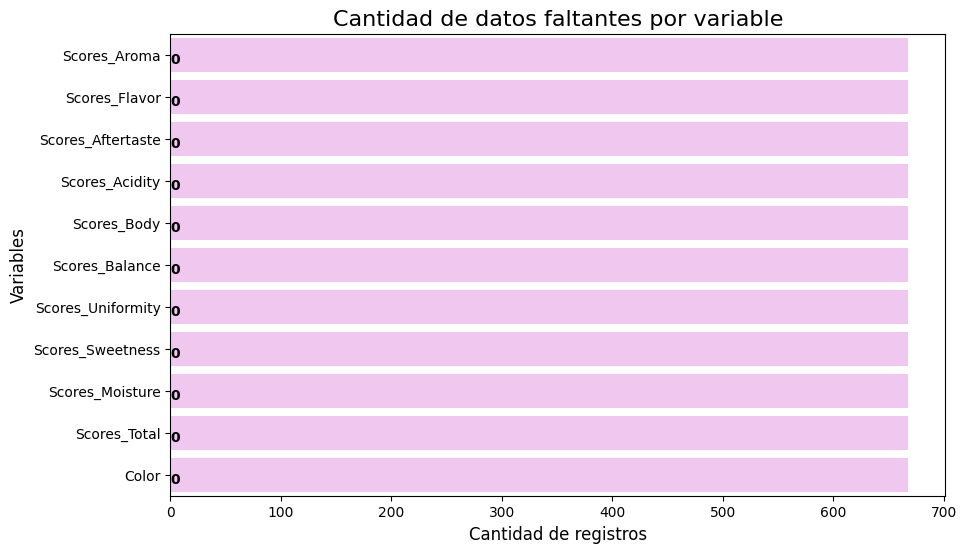

In [11]:
graficar_datos_faltantes(pd.concat([X_train, y_train], axis=1))

Tambien notemos las proporciones de elementos unicos de cada variable. Notar que la variable Score_total posee un rango de valores mucho mas amplio que el resto.

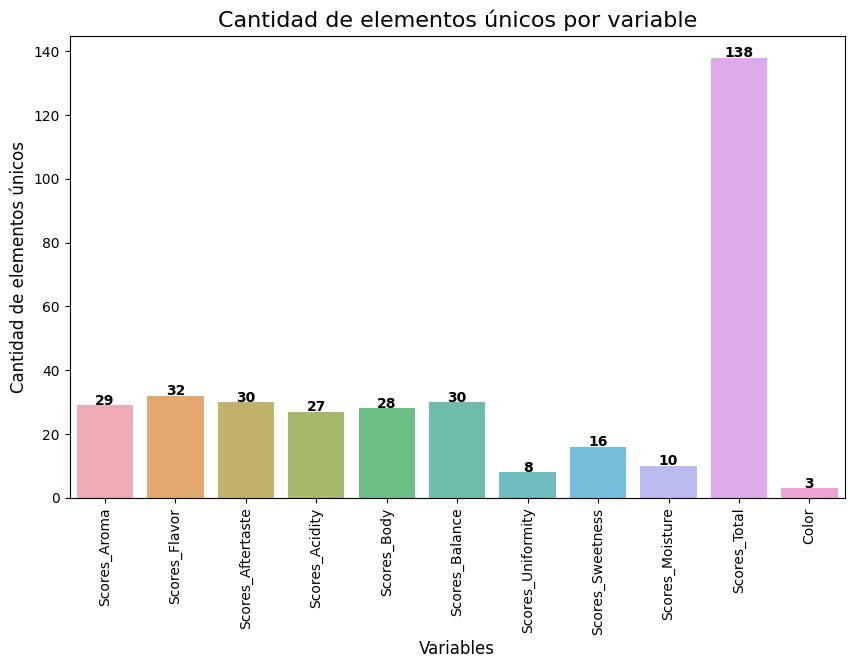

In [12]:
graficar_elementos_unicos(pd.concat([X_train, y_train], axis=1))

### Distribuciones por clase

El siguiente grafico es de utilidad para interpretar las distribuciones de las varibles numericas, separando por clases de la variable categorica.

In [13]:
def create_plots(X_train, y_train, explanatory_var, class_var, class_value):
    df = pd.concat([X_train, y_train], axis=1)
    if class_value != 'Todas':
        df = df[df[class_var] == class_value]

    fig, axs = plt.subplots(3, 1, figsize=(8,6))

    # scatter unidimensional
    sns.stripplot(x=explanatory_var, y=[""]*len(df), hue=class_var, data=df, jitter=True, ax=axs[0])
    axs[0].set_title('Distribución de ' + explanatory_var + ' con respecto a ' + class_var)
    axs[0].legend('')
    axs[0].set_xlabel("")

    # caja de metricas de distribucion
    sns.boxplot(y=class_var, x=explanatory_var, data=df, orient='h', ax=axs[1])
    axs[1].legend('')
    axs[1].set_xlabel("")

    # densidad de datos
    sns.kdeplot(data=df, x=explanatory_var, hue=class_var, fill=True, ax=axs[2])
    axs[2].set_xlabel(explanatory_var)
    axs[2].legend('')

    plt.tight_layout()
    plt.show()

# menu de seleccion de variable
explanatory_var_widget = widgets.Dropdown(
    options=[col for col in X_train.columns],
    description='Explicativa:',
)

# menu de seleccion de estado
class_value_widget = widgets.Dropdown(
    options=['Todas'] + list(y_train.unique()),
    description='Color:',
)

interact(create_plots, X_train=widgets.fixed(X_train), y_train=widgets.fixed(y_train), explanatory_var=explanatory_var_widget, class_var=widgets.fixed('Color'), class_value=class_value_widget)


interactive(children=(Dropdown(description='Explicativa:', options=('Scores_Aroma', 'Scores_Flavor', 'Scores_A…

<function __main__.create_plots(X_train, y_train, explanatory_var, class_var, class_value)>

Notas que en general poseemos distribuciones asimetricas, con presencia de calores atipicos de las tres clases en cada variable. Ademas generalemente las clases tienen distribuciones similares, salvo exceciones de variables como body, donde notamos que la clase de color Blue-Green tiene puntajes mas pequeños que las restantes.

### Distribuciones por variable

Notemos ahora distirbuciones de las variables considerando la totalidad de los datos para entender globalmente sus comportamientos.

In [14]:
def create_dist(X_train, y_train, variable):
    df = pd.concat([X_train, y_train], axis=1)
    # Crear un diccionario de colores unicos para cada variable
    color_dict = {col: color for col, color in zip(df.columns, sns.color_palette("hsv", len(df.columns)))}

    fig, ax = plt.subplots(figsize=(10, 4))

    # Boxplot
    bp = ax.boxplot(df[variable], patch_artist=True, vert=False)
    bp['boxes'][0].set_facecolor(color_dict[variable])
    bp['boxes'][0].set_alpha(0.7)

    # Violin plot (nubes)
    vp = ax.violinplot(df[variable], points=500, showmeans=False, showextrema=False, showmedians=False, vert=False)
    vp['bodies'][0].get_paths()[0].vertices[:, 1] = np.clip(vp['bodies'][0].get_paths()[0].vertices[:, 1], 0.8, 1.2)
    vp['bodies'][0].set_color(color_dict[variable])
    vp['bodies'][0].set_alpha(0.25)

    # Scatter plot (lluvia)
    y = np.full(len(df[variable]), 0.75) + np.random.uniform(low=-.05, high=.05, size=len(df[variable]))
    ax.scatter(df[variable], y, s=8, color=color_dict[variable], alpha=0.5)

    # Configurar títulos y etiquetas
    ax.set_title(variable)
    ax.set_yticks([])
    ax.set_xlabel("Value")

    plt.show()

# Crear selector de variable
variable_widget = widgets.Dropdown(
    options=[col for col in X_train], # no incluyo state por que es categoria
    description='Variable:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_dist, X_train=widgets.fixed(X_train), y_train=widgets.fixed(y_train), variable=variable_widget)


interactive(children=(Dropdown(description='Variable:', options=('Scores_Aroma', 'Scores_Flavor', 'Scores_Afte…

<function __main__.create_dist(X_train, y_train, variable)>

Notamos las mismas circunstancias que los graficos previos debido a las distirbuciones por clases no son tan diferentes las unas de las otras.

### Correlaciones

Podemos entender en una matriz de correlaciones como se relacionan y afectan las variables entre si.

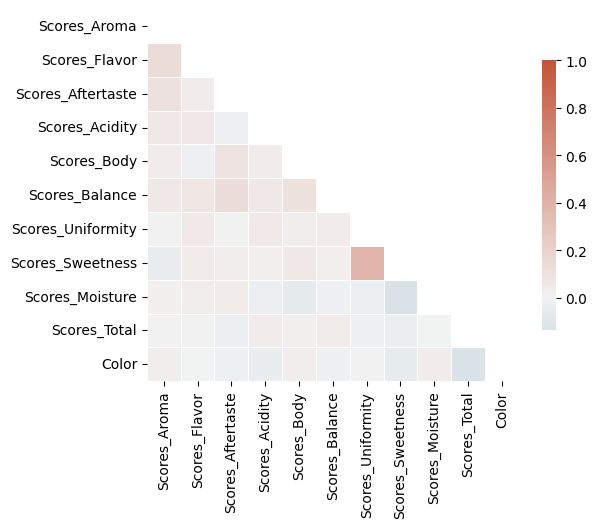

In [15]:

def grafico_correlacion(X_train, y_train, columnas):
    df_copy = pd.concat([X_train, y_train], axis=1)  # Hacer una copia del dataframe

    for columna in columnas:
        # Hacer un encoding de frecuencia para la variable categórica
        encoding = df_copy.groupby(columna).size()
        encoding = encoding / len(df_copy)
        df_copy[columna] = df_copy[columna].map(encoding)

    # Calcular la matriz de correlación
    corr = df_copy.corr()

    # Crear una máscara para el triángulo superior para no mostrar repetidos
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generar un mapa de colores divergentes personalizado
    fig, ax = plt.subplots(figsize=(6, 7))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Dibujar el mapa de calor con la máscara y la relación de aspecto correcta
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # Mostrar el gráfico
    plt.show()

grafico_correlacion(X_train, y_train, ['Color']) # state es la unica categorica aqui

Podemos ver que los valores son muy bajos en general. Podemos sugerir que casi parecen variables independientes entre asi, al menos considerando relaciones lineales solamente.

### Modelo base de clasificacion

La intecion de crear un model obase de clasificacion es tomar un punto de partida para conocer las estimaciones que realiza para la varible categorica. De este modelo base podemos obtener las metricas de validacion para entender su rendimiento ante el set de datos dado, y usar estas metricas como base para validar su mejora o no a lo largo de las transformaciones o cambios en el dataset o parametros.

In [96]:
def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    # Entrena el modelo SVM
    clf.fit(X_train, y_train)

    # Realiza las predicciones
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Calcula las probabilidades para el cálculo de AUC
    lb = LabelBinarizer()
    lb.fit(y_train)
    y_train_prob = clf.predict_proba(X_train)
    y_test_prob = clf.predict_proba(X_test)

    # accuracy para ambos sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # precision y recall para ambos sets y clases
    train_precision = precision_score(y_train, y_train_pred, average=None, zero_division=0)
    test_precision = precision_score(y_test, y_test_pred, average=None, zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average=None)
    test_recall = recall_score(y_test, y_test_pred, average=None)

    # f1 para ambos sets y clases
    train_f1 = f1_score(y_train, y_train_pred, average=None)
    test_f1 = f1_score(y_test, y_test_pred, average=None)

    # auc para ambos sets
    train_auc = roc_auc_score(lb.transform(y_train), y_train_prob, multi_class='ovr')
    test_auc = roc_auc_score(lb.transform(y_test), y_test_prob, multi_class='ovr')

    # Crear diccionario con los resultados para el conjunto de entrenamiento
    train_results = {
        'set': 'Train',
        'Blue-Green': {'accuracy': train_accuracy, 'precision': train_precision[0], 'recall': train_recall[0], 'f1': train_f1[0], 'auc': train_auc},
        'Bluish-Green': {'accuracy': train_accuracy, 'precision': train_precision[1], 'recall': train_recall[1], 'f1': train_f1[1], 'auc': train_auc},
        'Green': {'accuracy': train_accuracy, 'precision': train_precision[2], 'recall': train_recall[2], 'f1': train_f1[2], 'auc': train_auc},
    }

    # Crear diccionario con los resultados para el conjunto de prueba
    test_results = {
        'set': 'test',
        'Blue-Green': {'accuracy': test_accuracy, 'precision': test_precision[0], 'recall': test_recall[0], 'f1': test_f1[0], 'auc': test_auc},
        'Bluish-Green': {'accuracy': test_accuracy, 'precision': test_precision[1], 'recall': test_recall[1], 'f1': test_f1[1], 'auc': test_auc},
        'Green': {'accuracy': test_accuracy, 'precision': test_precision[2], 'recall': test_recall[2], 'f1': test_f1[2], 'auc': test_auc},
    }

    # Convertir los diccionarios a DataFrames
    train_df = pd.DataFrame(train_results).reset_index()
    test_df = pd.DataFrame(test_results).reset_index()

    result_clasif = pd.concat([train_df, test_df], axis=0)
    result_clasif.columns = ['metric', 'set', 'Blue-Green', 'Bluish-Green', 'Green']


    print(classification_report(y_test, y_test_pred, zero_division=0))
    display(result_clasif.sort_values(by='metric'))
    return clf


In [97]:
model = svm.SVC(probability=True)
train_and_evaluate(model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        20
       Green       0.81      1.00      0.89       135

    accuracy                           0.81       167
   macro avg       0.27      0.33      0.30       167
weighted avg       0.65      0.81      0.72       167



,metric,set,Blue-Green,Bluish-Green,Green
0,accuracy,Train,0.817365,0.817365,0.817365
0,accuracy,test,0.808383,0.808383,0.808383
4,auc,Train,0.576118,0.576118,0.576118
4,auc,test,0.575186,0.575186,0.575186
3,f1,Train,0.000000,0.000000,0.899506
3,f1,test,0.000000,0.000000,0.894040
1,precision,Train,0.000000,0.000000,0.817365
1,precision,test,0.000000,0.000000,0.808383
2,recall,Train,0.000000,0.000000,1.000000
2,recall,test,0.000000,0.000000,1.000000


SVC(probability=True)

Notamos metricas que demuestran sobreajuste del modelo en los datos de entrenamiento, aunque muy leve. Ademas notamos que solo una de las clases posee metricas de F1 Score, las restantes son nulas. Esto implica que el dataset esta desbalanceado para esta clase.

### Balanceo de clases

El siguiente grafico demuestra las proprciones de registros de cada clase.

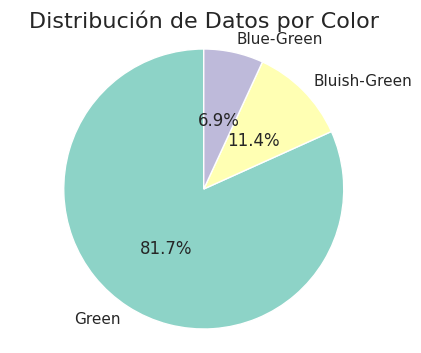

In [98]:
def graficar_proporcion_datos(X_train, y_train, column):
    df = pd.concat([X_train, y_train], axis=1)
    value_counts = df[column].value_counts() # cantidad de calores de cada clase

    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 4))

    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.5, colors=sns.color_palette('Set3')) # visualizacion en pie chart

    plt.title(f'Distribución de Datos por {column}', fontsize=16)
    plt.axis('equal')

    plt.show()

graficar_proporcion_datos(X_train, y_train, 'Color')

Notamos la razon del gran desbalance, ya que solo una de las clases posee la gran mayoria de los registros del conjunto.

Para tratar este caso, podemos tratas de balancear manualmente el conjunto para llevar a proporicones similares los registros de cada clase. Esto probando primeramente mediante tecnicas de oversampling.

In [99]:
def over_classes(X, y):
    # Crear el objeto SMOTE
    smote = SMOTE(sampling_strategy={'Green': 546, 'Blue-Green': 480, 'Bluish-Green': 480}, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    print(f'shape balanceado: {X_res.shape[0]}')

    # Devolver el DataFrame balanceado
    return X_res, y_res

# Llamada a la función
X_train_over, y_train_over = over_classes(X_train, y_train)
print(f'shape original: {coffee.shape[0]}')

shape balanceado: 1506
shape original: 835


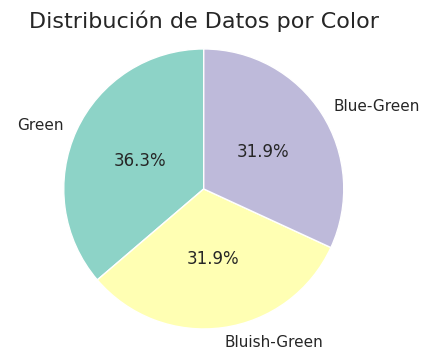

In [100]:
graficar_proporcion_datos(X_train_over, y_train_over, 'Color')

In [101]:
model_over = svm.SVC(probability=True)
train_and_evaluate(model_over, X_train_over, X_test, y_train_over, y_test)

              precision    recall  f1-score   support

  Blue-Green       0.06      0.33      0.10        12
Bluish-Green       0.12      0.30      0.17        20
       Green       0.82      0.31      0.45       135

    accuracy                           0.31       167
   macro avg       0.34      0.31      0.24       167
weighted avg       0.68      0.31      0.39       167



,metric,set,Blue-Green,Bluish-Green,Green
0,accuracy,Train,0.491368,0.491368,0.491368
0,accuracy,test,0.311377,0.311377,0.311377
4,auc,Train,0.707549,0.707549,0.707549
4,auc,test,0.528285,0.528285,0.528285
3,f1,Train,0.593528,0.453191,0.375155
3,f1,test,0.101266,0.173913,0.451613
1,precision,Train,0.477764,0.463043,0.583012
1,precision,test,0.059701,0.122449,0.823529
2,recall,Train,0.783333,0.443750,0.276557
2,recall,test,0.333333,0.300000,0.311111


SVC(probability=True)

Notamos que ahora si el modelo base puede generar metricas para la matrix de confusion en las clases minoritarias debido a que pobló el dataset con datos de esas clases de forma sintetica. Pero a su vez abrio aun mas la brecha del baance del modelo, generando un sobreajuste importante.

Podemos probar con tecnicas de submuestreo.

In [102]:
def under_sample_classes(X, y):
    # Crear el objeto RandomUnderSampler
    rus = RandomUnderSampler(sampling_strategy={'Green': 100}, random_state=42)
    X_res, y_res = rus.fit_resample(X, y)

    print(f'shape balanceado: {X_res.shape[0]}')

    # Devolver el DataFrame balanceado
    return X_res, y_res

# Llamada a la función
X_train_under, y_train_under = under_sample_classes(X_train, y_train)
print(f'shape original: {coffee.shape[0]}')


shape balanceado: 222
shape original: 835


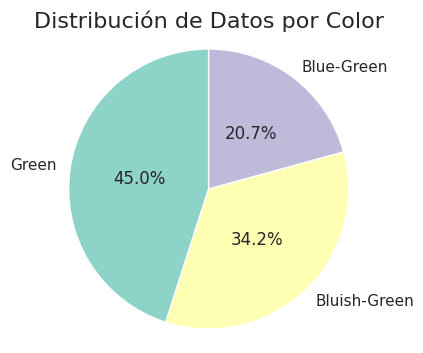

In [103]:
graficar_proporcion_datos(X_train_under, y_train_under, 'Color')

In [104]:
model_under = svm.SVC(probability=True)
train_and_evaluate(model_under, X_train_under, X_test, y_train_under, y_test)

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        20
       Green       0.81      1.00      0.89       135

    accuracy                           0.81       167
   macro avg       0.27      0.33      0.30       167
weighted avg       0.65      0.81      0.72       167



,metric,set,Blue-Green,Bluish-Green,Green
0,accuracy,Train,0.450450,0.450450,0.450450
0,accuracy,test,0.808383,0.808383,0.808383
4,auc,Train,0.572351,0.572351,0.572351
4,auc,test,0.538626,0.538626,0.538626
3,f1,Train,0.000000,0.000000,0.621118
3,f1,test,0.000000,0.000000,0.894040
1,precision,Train,0.000000,0.000000,0.450450
1,precision,test,0.000000,0.000000,0.808383
2,recall,Train,0.000000,0.000000,1.000000
2,recall,test,0.000000,0.000000,1.000000


SVC(probability=True)

Las metricas en general han disminuido con respecto al modelo inicial, y el problema del desbalance no se ha solucionado. Asi que ignoramos este enfoque por el momento.

### Reduccion de dimensionalidad

Inicialmente se busca visualizar la distribucion de todo el conjunto de datos en un espacio de dimencionalidad reducida, distiguiendo cada clase con un color diferente.

columnas de coffee: 10


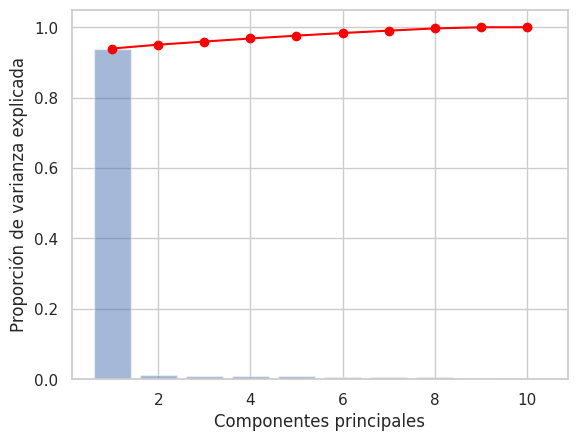

In [105]:
#--- Obtencion de los componentes ---#
pca = PCA()

X_train_pca_result = pca.fit_transform(X_train)
X_test_pca_result = pca.transform(X_test)

X_train_pca = pd.DataFrame(data=X_train_pca_result, columns=[f"PC{i+1}" for i, _ in enumerate(X_train.columns)]) # genera un df de las componentes
X_test_pca = pd.DataFrame(data=X_test_pca_result, columns=[f"PC{i+1}" for i, _ in enumerate(X_test.columns)]) # genera un df de las componentes

#--- Explicabilidad de los componentes ---#

varianza = np.cumsum(pca.explained_variance_ratio_)

acum = pd.DataFrame({"Component": X_train_pca.columns,
                     "EigenValues": pca.explained_variance_,
                     "PropVar": pca.explained_variance_ratio_,
                     "VarAcum": varianza}) # aca interesa la varianza acumulada, que se asemeja al porcentaje de explicabilidad de los datos


print(f'columnas de coffee: {X_train.shape[1]}')

#--- grafico de explicabilidad ---#

plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align="center")
plt.plot(range(1, 11), varianza, marker="o" ,color="red")
plt.ylabel("Proporción de varianza explicada")
plt.xlabel("Componentes principales")
plt.show()


Un solo componente principal puede explicar en su mayoria todo el conjunto de datos.

Aun asi utilizamos tres variables para mejor visualizacion

In [106]:
fig = px.scatter_3d(X_train_pca, x='PC1', y='PC2', z='PC3', color=y_train)
fig.show()

Podemos probar agregar esa componente con alta explicabilidad al conjunto de datos para ver si ayuda al modelo a mejorar las predicciones.

In [107]:
X_train_reduced = X_train_pca[[f"PC{i}" for i in range(1, 4)]] # consideramos solo los primeros dos componentes
X_test_reduced = X_test_pca[[f"PC{i}" for i in range(1, 4)]]

X_train_with_pca = pd.concat([X_train.reset_index(drop=True), X_train_reduced], axis=1)
X_test_with_pca = pd.concat([X_test.reset_index(drop=True), X_test_reduced], axis=1)

model_pca = svm.SVC(probability=True)
train_and_evaluate(model_pca, X_train_with_pca, X_test_with_pca, y_train, y_test)

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        20
       Green       0.81      1.00      0.89       135

    accuracy                           0.81       167
   macro avg       0.27      0.33      0.30       167
weighted avg       0.65      0.81      0.72       167



,metric,set,Blue-Green,Bluish-Green,Green
0,accuracy,Train,0.817365,0.817365,0.817365
0,accuracy,test,0.808383,0.808383,0.808383
4,auc,Train,0.639114,0.639114,0.639114
4,auc,test,0.543665,0.543665,0.543665
3,f1,Train,0.000000,0.000000,0.899506
3,f1,test,0.000000,0.000000,0.894040
1,precision,Train,0.000000,0.000000,0.817365
1,precision,test,0.000000,0.000000,0.808383
2,recall,Train,0.000000,0.000000,1.000000
2,recall,test,0.000000,0.000000,1.000000


SVC(probability=True)

El impacto no es alto como el esperado, asi que se ignora este enfoque.

### Valores Atipicos

Contamos con presencencia de valores atipicos de forma sistematica en todas las variables numericas. Un enfoque simple podria ser simplemente eliminarlos, de forma que solo nos quedamos con los rangos de valores mayoritarios.

In [108]:
def remove_outliers(X_train, X_test, y_train, y_test):
    Q1 = X_train.quantile(0.25)
    Q3 = X_train.quantile(0.75)
    IQR = Q3 - Q1

    # Solo mantener las filas en el conjunto de entrenamiento que están dentro del rango intercuartil
    train_mask = ((X_train >= (Q1 - 1.5 * IQR)) & (X_train <= (Q3 + 1.5 * IQR))).all(axis=1)
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]

    # Solo mantener las filas en el conjunto de prueba que están dentro del rango intercuartil
    test_mask = ((X_test >= (Q1 - 1.5 * IQR)) & (X_test <= (Q3 + 1.5 * IQR))).all(axis=1)
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]

    return X_train, X_test, y_train, y_test

# Uso de la función
X_train_out, X_test_out, y_train_out, y_test_out = remove_outliers(X_train_over, X_test, y_train_over, y_test)

In [109]:

# Crear selector de variable
variable_widget = widgets.Dropdown(
    options=[col for col in X_train_out], # no incluyo state por que es categoria
    description='Variable:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_dist, X_train=widgets.fixed(X_train_out), y_train=widgets.fixed(y_train_out), variable=variable_widget)


interactive(children=(Dropdown(description='Variable:', options=('Scores_Aroma', 'Scores_Flavor', 'Scores_Afte…

<function __main__.create_dist(X_train, y_train, variable)>

In [110]:
model_out = svm.SVC(probability=True)
train_and_evaluate(model_out, X_train_out, X_test_out, y_train_out, y_test_out)

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         3
Bluish-Green       0.18      1.00      0.31         6
       Green       0.00      0.00      0.00        24

    accuracy                           0.18        33
   macro avg       0.06      0.33      0.10        33
weighted avg       0.03      0.18      0.06        33



,metric,set,Blue-Green,Bluish-Green,Green
0,accuracy,Train,0.403030,0.403030,0.403030
0,accuracy,test,0.181818,0.181818,0.181818
4,auc,Train,0.631889,0.631889,0.631889
4,auc,test,0.493313,0.493313,0.493313
3,f1,Train,0.000000,0.574514,0.000000
3,f1,test,0.000000,0.307692,0.000000
1,precision,Train,0.000000,0.403030,0.000000
1,precision,test,0.000000,0.181818,0.000000
2,recall,Train,0.000000,1.000000,0.000000
2,recall,test,0.000000,1.000000,0.000000


SVC(probability=True)

La decision de eliminar los datos que resultan muy distintos a las mayoria conlleva a un impacto negativo en el modelo base de clasificacion, ademas de tender al sobreajuste.

### Escalado de datos

Notamos que los rangos de valores de cada variable difiere en algunos casos muy poco, y en otros difieren bastent. Por lo que se propone escalar los valores para llevar todas las variables al mismo rango de valores.

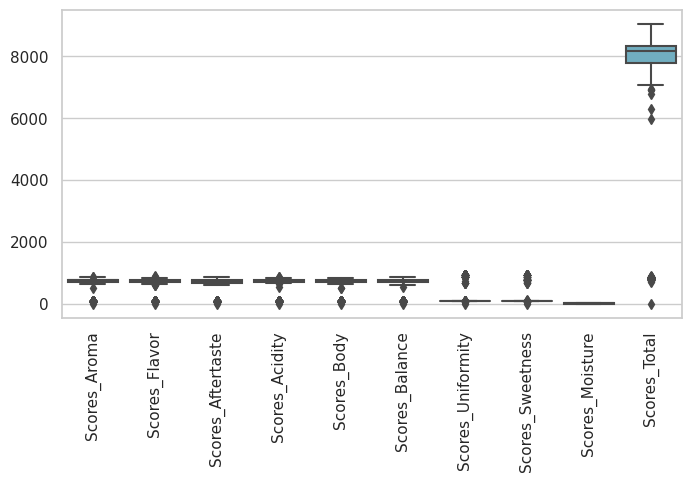

In [111]:
def show_distrbutions(df):
    plt.figure(figsize=(8, 4))
    sns.boxplot(df)
    plt.xticks(rotation=90)
    plt.show()

show_distrbutions(coffee)

In [112]:
def estandarize(X_train, scale_type, scaler_trained=None):
  data = X_train.copy()

  scalers = {'Standard': StandardScaler(),
               'MinMax': MinMaxScaler(),
               'Robust': RobustScaler()}
  if scaler_trained is None:
    scaler = scalers[scale_type]
  else:
    scaler = scaler_trained

  data_scaled = scaler.fit_transform(data)
  data_standardized = pd.DataFrame(data_scaled, columns=data.columns)

  if scaler_trained is None:
    return data_standardized, scaler
  else:
    return data_standardized

# Function to perform the selected standardization method
def perform_standardization(method):

    df_scaled, scaler = estandarize(X_train_out, method, None)
    show_distrbutions(df_scaled)

# Dropdown widget for selecting the standardization method
standardization_dropdown = widgets.Dropdown(
    options=['Standard', 'MinMax', 'Robust'],
    value='Standard',
    description='Method:',
    disabled=False,
)

# Define an interactive output widget
output = widgets.interactive_output(perform_standardization, {'method': standardization_dropdown})

# Display the widgets
display(standardization_dropdown, output)


Dropdown(description='Method:', options=('Standard', 'MinMax', 'Robust'), value='Standard')

Output()

In [113]:
X_train_standar, scaler_standar = estandarize(X_train, 'Standard', None)
X_test_standar = estandarize(X_test, 'Standard', scaler_standar)

In [114]:
model_standar = svm.SVC(probability=True)
train_and_evaluate(model_standar, X_train_standar, X_test_standar, y_train, y_test)

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        20
       Green       0.81      1.00      0.89       135

    accuracy                           0.81       167
   macro avg       0.27      0.33      0.30       167
weighted avg       0.65      0.81      0.72       167



,metric,set,Blue-Green,Bluish-Green,Green
0,accuracy,Train,0.820359,0.820359,0.820359
0,accuracy,test,0.808383,0.808383,0.808383
4,auc,Train,0.703807,0.703807,0.703807
4,auc,test,0.556835,0.556835,0.556835
3,f1,Train,0.000000,0.051282,0.900990
3,f1,test,0.000000,0.000000,0.894040
1,precision,Train,0.000000,1.000000,0.819820
1,precision,test,0.000000,0.000000,0.808383
2,recall,Train,0.000000,0.026316,1.000000
2,recall,test,0.000000,0.000000,1.000000


SVC(probability=True)

Notamos un impacto negativo a la hora es escalar los datos con cualquera de los enfoques seleccionados, por lo que se ignora este apartado.

### Conclusion

Todos los tratamientos de reduccion de dimencionalidad, oversmapling, undersampling, tratamiento de valores atipicos, y estandarizacion de valores, mejoran en general las metricas, pero genera mucho desbalanceo (overfitting muy brusco). Asi que lo mejor es no manipual el dataset como tal, sino buscar reducir la influencia de estos rasgos mediante hiperparametrizacion del modelo de support vector machine.

## **Segundo ejercicio**

---

Realizar la predicción del atributo Color utilizando máquinas de vectores con kernel lineal
analizando el parámetro costo. Mostar los resultados sobre los conjuntos de test
(Precisión, Exhaustividad y Exactitud) utilizando validación cruzada con k =5

---

### Hiperarametricacion de C

Podemos explorar iterando con ditintos valores para el parametro C, buscando aquel que minimize el error de prediccion de las clases.

Definimos el error como 1 - el accuaracy del modelo.

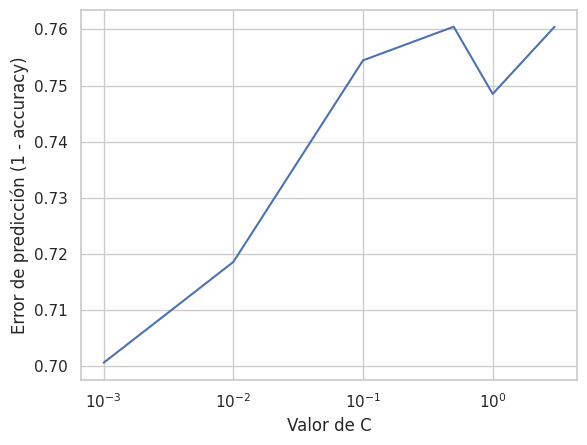

In [128]:
def evaluate_c(X_train, X_test, y_train, y_test, C):
    # Ajustar el modelo con el valor de C dado
    model = svm.SVC(C=C, kernel="linear", random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)

    # Hacer las predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcular el error de predicción usando 1 - accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy

    # Retornar el valor de C y el valor de error
    return C, test_error

# Crear una lista de valores de C a probar
C_values = [0.001, 0.01, 0.1, 0.5, 1, 3]

# Crear un diccionario vacío para guardar los resultados
results = {}

# Iterar sobre la lista de valores de C
for C in C_values:
    # Llamar a la función con el modelo y los conjuntos de datos
    C, error = evaluate_c(X_train, X_test, y_train, y_test, C)
    # Guardar el resultado en el diccionario
    results[C] = error

# Crear un gráfico de línea que muestre el error de predicción vs el valor de C
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel('Valor de C')
plt.ylabel('Error de predicción (1 - accuracy)')
plt.xscale('log')
plt.show()


Este grafico inidica que el menor error ocurre cuando el parametro de costo es de 0.01, por lo que sera nuestro valor elejido.

In [126]:
grid = GridSearchCV(
    estimator=svm.SVC(kernel="linear", random_state=42, class_weight='balanced'),
    param_grid={"C": [0.001, 0.01, 0.1, 0.5, 1, 3]},
    scoring="accuracy",
    n_jobs=3,
    verbose=1,
    cv=5,
    return_train_score=True
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', kernel='linear',
                           random_state=42),
             n_jobs=3, param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 3]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [127]:
grid.best_estimator_.C

0.001

### Definicion de modelo

Como ya encontramos el parametro que minimiza el error asignadole costos a las clases, podemos contruir un modelo formar con este enfoque de kernel lineal con el parametro c adecuado, y balancenado dentro del algoritmo los pesos que se les asigna a cada clase.

In [129]:
modelo_lineal = svm.SVC(C=0.001, kernel="linear", random_state=42, class_weight='balanced', probability=True)
modelo_lineal = train_and_evaluate(modelo_lineal, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

  Blue-Green       0.05      0.20      0.08        10
Bluish-Green       0.15      0.68      0.25        19
       Green       0.83      0.25      0.39       138

    accuracy                           0.30       167
   macro avg       0.35      0.38      0.24       167
weighted avg       0.71      0.30      0.35       167



,metric,set,Blue-Green,Bluish-Green,Green
0,accuracy,Train,0.320359,0.320359,0.320359
0,accuracy,test,0.299401,0.299401,0.299401
4,auc,Train,0.644514,0.644514,0.644514
4,auc,test,0.604590,0.604590,0.604590
3,f1,Train,0.238683,0.233503,0.397711
3,f1,test,0.080000,0.250000,0.388889
1,precision,Train,0.148718,0.145110,0.891026
1,precision,test,0.050000,0.152941,0.833333
2,recall,Train,0.604167,0.597403,0.255985
2,recall,test,0.200000,0.684211,0.253623


Podemos observar en una matriz de correlacion en que clases el modelo tiende a equivocarse mas y de que forma.

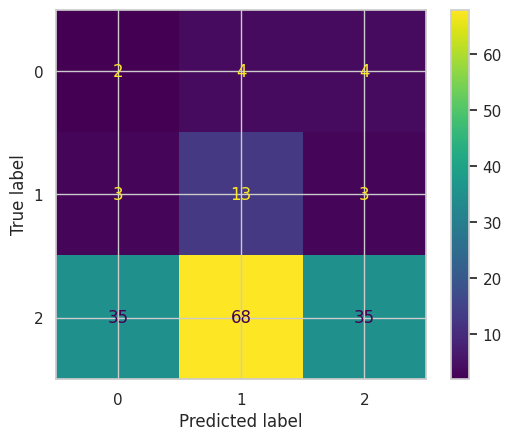

In [130]:
pred = modelo_lineal.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()

Es este caso, la matriz de confuncion indica alta presencia de falsos positivos.

### Validacion cruzada

Podemos obtener como las metricas se comportan con las distintas combinaciones de conjuntos para train y testing, y obtener metricas que agrupan a las mismas.

In [131]:
# Separamos las características y la variable objetivo
X = coffee.drop('Color', axis=1)
y = coffee['Color']

# Creamos el modelo SVM
modelo_lineal_final = svm.SVC(C=0.001, kernel="linear", random_state=42, class_weight='balanced')

# Creamos el objeto de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar los resultados de cada iteración
precisiones = []
exhaustividades = []
exactitudes = []

# Bucle para realizar la validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenamos el modelo
    modelo_lineal_final.fit(X_train, y_train)

    # Realizamos las predicciones
    y_pred = modelo_lineal_final.predict(X_test)

    # Calculamos las métricas y las añadimos a las listas
    precisiones.append(precision_score(y_test, y_pred, average='macro'))
    exhaustividades.append(recall_score(y_test, y_pred, average='macro'))
    exactitudes.append(accuracy_score(y_test, y_pred))

# Calculamos la media de las métricas
precision_media = np.mean(precisiones)
exhaustividad_media = np.mean(exhaustividades)
exactitud_media = np.mean(exactitudes)

print(f'Precisión media: {precision_media}')
print(f'Exhaustividad media: {exhaustividad_media}')
print(f'Exactitud media: {exactitud_media}')


Precisión media: 0.35950901300356874
Exhaustividad media: 0.39206465187553197
Exactitud media: 0.29940119760479045


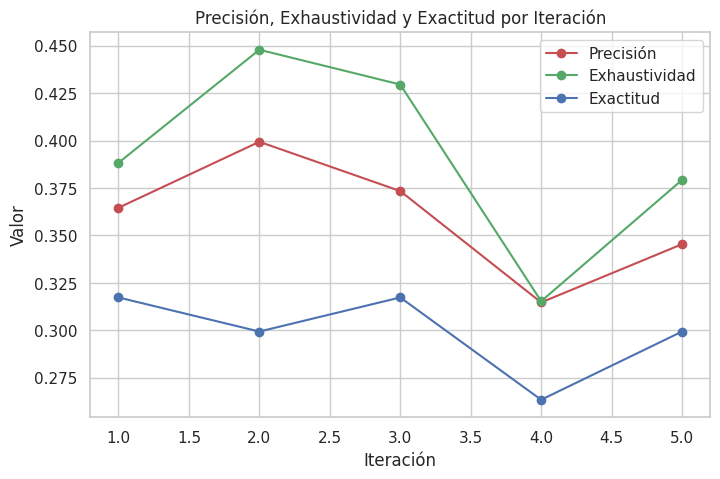

In [132]:
# Creamos el eje x para el gráfico
eje_x = range(1, len(precisiones) + 1)

plt.figure(figsize=(8, 5))

# Graficamos las precisiones
plt.plot(eje_x, precisiones, marker='o', linestyle='-', color='r', label='Precisión')

# Graficamos las exhaustividades
plt.plot(eje_x, exhaustividades, marker='o', linestyle='-', color='g', label='Exhaustividad')

# Graficamos las exactitudes
plt.plot(eje_x, exactitudes, marker='o', linestyle='-', color='b', label='Exactitud')

plt.xlabel('Iteración')
plt.ylabel('Valor')
plt.title('Precisión, Exhaustividad y Exactitud por Iteración')
plt.legend()

plt.show()

### Visualizacion de clasificacion

El siguiente grafico puede ser de utilidad para ver como el modelo de clasificacion divide en el espacio las clases clases.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



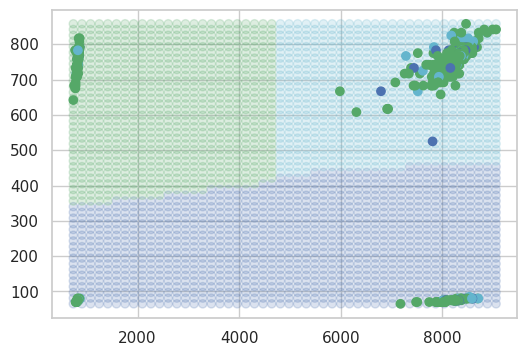

In [133]:
modelo_sub = svm.SVC(C=0.001, kernel="linear", random_state=42, class_weight='balanced', probability=True)
X_train_subset = X_train[['Scores_Total', 'Scores_Balance']]

# Ajusta el modelo con el subconjunto de datos
modelo_sub.fit(X_train_subset, y_train)


x = np.linspace(np.min(X_train_subset['Scores_Total']), np.max(X_train_subset['Scores_Total']), 50)
y = np.linspace(np.min(X_train_subset['Scores_Balance']), np.max(X_train_subset['Scores_Balance']), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

pred_grid = pd.Series(modelo_sub.predict(grid))

fig, ax = plt.subplots(figsize=(6,4))
colores = {'Green':'g', 'Blue-Green':'b', 'Bluish-Green':'c'}
ax.scatter(grid[:,0], grid[:,1], c=pred_grid.map(colores), alpha = 0.2)
ax.scatter(X_train_subset['Scores_Total'], X_train_subset['Scores_Balance'], c=y_train.map(colores), alpha = 1)

Los datos son reales de train solo para dos variables para facilidad de visualizacion, y los colores del fondo indican la clase a la que pertence ese espacio.

Notamos que no realiza un buen trabajo este algoritmo para la clasificacion.

## **Tercer ejercicio**

---

Realizar la predicción del atributo Color utilizando máquinas de vectores con kernel
gaussiano analizando los parámetros costo y gama. Mostar los resultados sobre los
conjuntos de test (Precisión, Exhaustividad y Exactitud) utilizando validación cruzada con
k =5.

---

### Hiperparametrizacion

A continuacion se hacen pruebas de busqueda autamatica de los mejores parametros dentro de un dominio de valores dados para un algoritmo de support vector machine, pero esta vez utilizando un kernel no lineal Gaussiano.

In [134]:
grid_gauss = GridSearchCV(
    estimator = svm.SVC(kernel="rbf", random_state=42, class_weight='balanced'),
    param_grid={
        "C": [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 200],
        "gamma": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]
    },
    scoring="accuracy",
    n_jobs=3,
    verbose=1,
    cv=5,
    return_train_score=True
)

grid_gauss.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             n_jobs=3,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 200],
                         'gamma': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [194]:
print(f'Mejor valor de C: {grid_gauss.best_estimator_.C}')
print(f'Mejor valor de gamma: {grid_gauss.best_estimator_.gamma}')

Mejor valor de C: 0.5
Mejor valor de gamma: 0.01


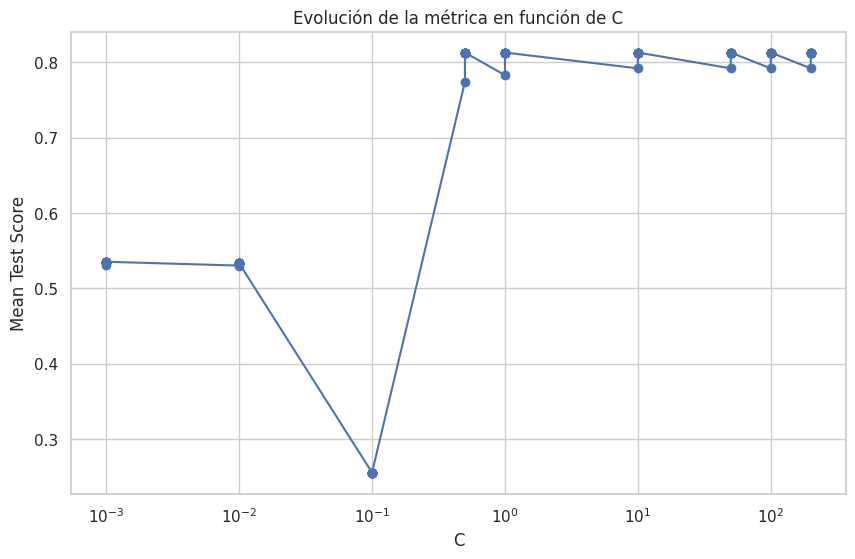

In [147]:
results = pd.DataFrame(grid_gauss.cv_results_)

# Filtra los resultados para obtener solo la información relevante
param_C_values = results['param_C'].astype(float)
mean_test_scores = results['mean_test_score']

# Crea el gráfico
plt.figure(figsize=(10, 6))

# Gráfico para el parámetro C
plt.plot(param_C_values, mean_test_scores, marker='o')
plt.xscale('log')  # Escala logarítmica para C
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title('Evolución de la métrica en función de C')

# Muestra el gráfico
plt.show()


### Seleccion

Si bien las metircas han mejorado debido a que el modelo se equivoca menos, ahora tenemos un sesgo debido a que clasifica correctamente solo la clase mayoritarai a pesar de haber configurado el parametro de los pesos como balanceado.

In [154]:
pred_gauss = grid_gauss.predict(X_test)
print(classification_report(y_test, pred_gauss, zero_division=0))

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        10
Bluish-Green       0.00      0.00      0.00        19
       Green       0.83      1.00      0.90       138

    accuracy                           0.83       167
   macro avg       0.28      0.33      0.30       167
weighted avg       0.68      0.83      0.75       167



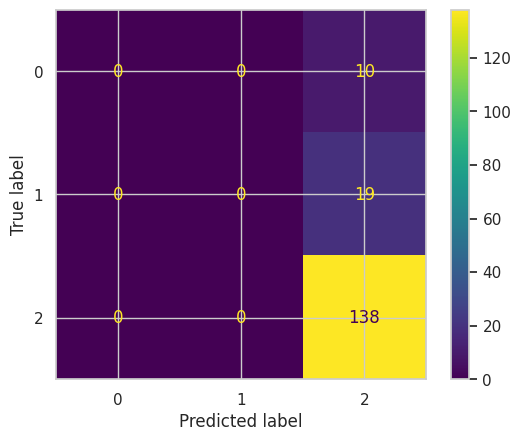

In [155]:
ConfusionMatrixDisplay(confusion_matrix(y_test, pred_gauss)).plot()

### Validacion Cruzada

Obtenemos las metricas en cada iteracion de la validacion cruzada, y un promedio de las mismas como metrica general del modelo.

In [190]:
# Separamos las características y la variable objetivo
X = coffee.drop('Color', axis=1)
y = coffee['Color']

# Creamos el modelo SVM
modelo_sub = svm.SVC(C=0.5, gamma=0.01, kernel="rbf", random_state=42, class_weight='balanced')

# Creamos el objeto de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar los resultados de cada iteración
precisiones = []
exhaustividades = []
exactitudes = []

# Bucle para realizar la validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenamos el modelo
    modelo_sub.fit(X_train, y_train)

    # Realizamos las predicciones
    y_pred = modelo_sub.predict(X_test)

    # Calculamos las métricas y las añadimos a las listas
    precisiones.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    exhaustividades.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
    exactitudes.append(accuracy_score(y_test, y_pred))

# Calculamos la media de las métricas
precision_media = np.mean(precisiones)
exhaustividad_media = np.mean(exhaustividades)
exactitud_media = np.mean(exactitudes)

print(f'Precisión media: {precision_media}')
print(f'Exhaustividad media: {exhaustividad_media}')
print(f'Exactitud media: {exactitud_media}')


Precisión media: 0.27185628742514967
Exhaustividad media: 0.3333333333333333
Exactitud media: 0.8155688622754491


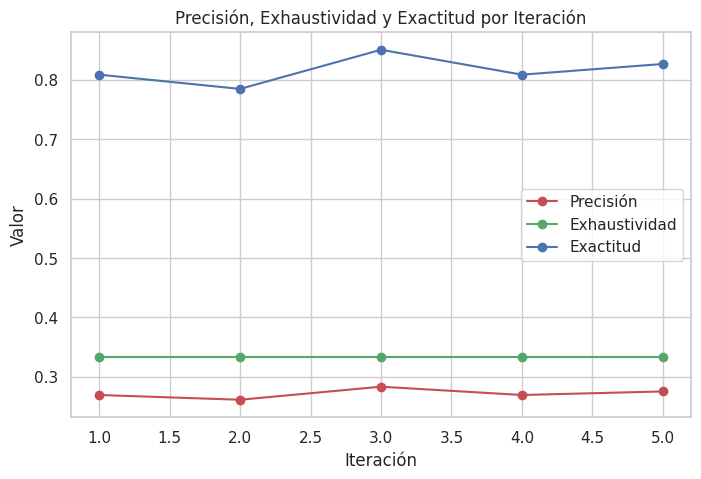

In [191]:
# Creamos el eje x para el gráfico
eje_x = range(1, len(precisiones) + 1)

plt.figure(figsize=(8, 5))

# Graficamos las precisiones
plt.plot(eje_x, precisiones, marker='o', linestyle='-', color='r', label='Precisión')

# Graficamos las exhaustividades
plt.plot(eje_x, exhaustividades, marker='o', linestyle='-', color='g', label='Exhaustividad')

# Graficamos las exactitudes
plt.plot(eje_x, exactitudes, marker='o', linestyle='-', color='b', label='Exactitud')

plt.xlabel('Iteración')
plt.ylabel('Valor')
plt.title('Precisión, Exhaustividad y Exactitud por Iteración')
plt.legend()

plt.show()

### Visualizacion de clasificacion

Es solo un ejemplo de visualizacion de como clasifica este nuevo modelo con dos variables explicativas.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



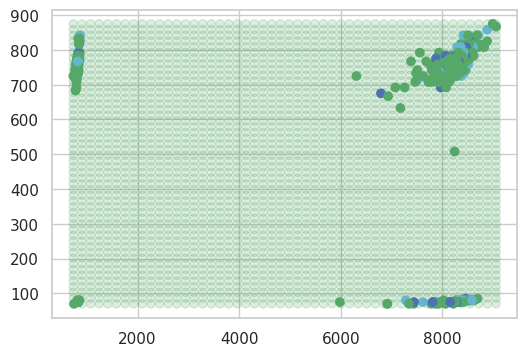

In [158]:
modelo_sub = svm.SVC(C=0.5, gamma=0.01, kernel="rbf", random_state=42, class_weight='balanced')
X_train_subset = X_train[['Scores_Total', 'Scores_Aroma']]

# Ajusta el modelo con el subconjunto de datos
modelo_sub.fit(X_train_subset, y_train)

x = np.linspace(np.min(X_train_subset['Scores_Total']), np.max(X_train_subset['Scores_Total']), 50)
y = np.linspace(np.min(X_train_subset['Scores_Aroma']), np.max(X_train_subset['Scores_Aroma']), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

pred_grid = pd.Series(modelo_sub.predict(grid))

fig, ax = plt.subplots(figsize=(6,4))
colores = {'Green':'g', 'Blue-Green':'b', 'Bluish-Green':'c'}
ax.scatter(grid[:,0], grid[:,1], c=pred_grid.map(colores), alpha = 0.2)
ax.scatter(X_train_subset['Scores_Total'], X_train_subset['Scores_Aroma'], c=y_train.map(colores), alpha = 1)

No parace clasificar en lo absoluto. De hecho se corresponde a los que indicaba la metrica. Predice mayor o totalmente en la clase Green y no en las demas. O a lo mejor no podemos como trabaja debido a una limitacion de la dimencionalidad.

## **Cuarto ejercicio**

---

Realizar la predicción del atributo Color utilizando Random Forest analizando los
parámetros cantidad de estimadores y la máxima profundidad de los árboles. Mostar los
resultados sobre los conjuntos de test (Precisión, Exhaustividad y Exactitud) utilizando
validación cruzada con k =5.

---

### Hiperparametrizacion


Probamos un nuevo algoritmo de clasificacion basado en arboles que no se ve afectado por la presencia de valores atipicos ni desbalanceos, por lo que no es necesario parametrizar ni transformar los datos en este caso.

Se hace una seleccion automatica de los mejores hiperparametros mediante una tecnica de RandomizedSeachCV.

In [166]:
rscv = RandomizedSearchCV(
        RandomForestClassifier(),
        param_distributions={
        "n_estimators": np.arange(1, 500),
        "max_depth": np.arange(1, 30)},
        n_jobs=3,
        n_iter=5,
        cv=5,
        return_train_score=True
    )

rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5, n_jobs=3,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47...
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499])},
                   return_train_score=True)

In [167]:
rscv.best_params_

{'n_estimators': 376, 'max_depth': 5}

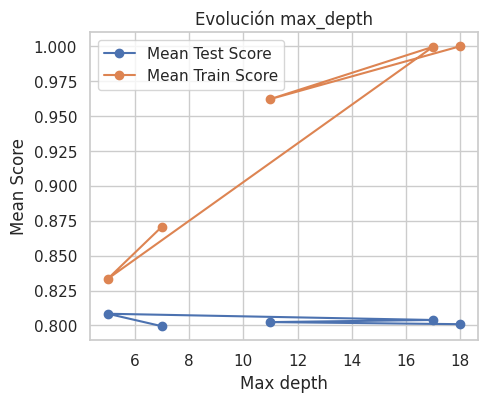

In [182]:
# Datos de RandomizedSearchCV
n_estimators_values = [param['max_depth'] for param in rscv.cv_results_['params']]
mean_test_scores = rscv.cv_results_['mean_test_score']
mean_train_scores = rscv.cv_results_['mean_train_score']

# Crear el gráfico de líneas
plt.figure(figsize=(5, 4))
plt.plot(n_estimators_values, mean_test_scores, label='Mean Test Score', marker='o')
plt.plot(n_estimators_values, mean_train_scores, label='Mean Train Score', marker='o')

# Añadir etiquetas y título
plt.xlabel('Max depth')
plt.ylabel('Mean Score')
plt.title('Evolución max_depth')
plt.legend()
plt.grid(True)
plt.show()


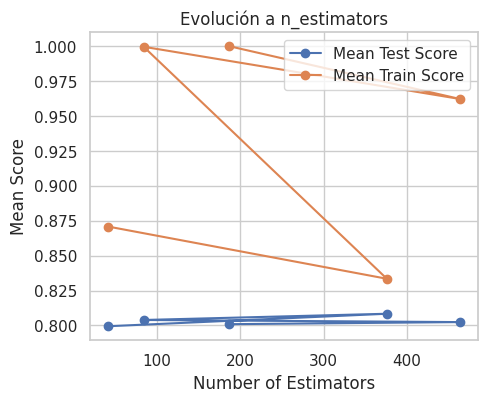

In [183]:
# Datos de RandomizedSearchCV
n_estimators_values = [param['n_estimators'] for param in rscv.cv_results_['params']]
mean_test_scores = rscv.cv_results_['mean_test_score']
mean_train_scores = rscv.cv_results_['mean_train_score']

# Crear el gráfico de líneas
plt.figure(figsize=(5, 4))
plt.plot(n_estimators_values, mean_test_scores, label='Mean Test Score', marker='o')
plt.plot(n_estimators_values, mean_train_scores, label='Mean Train Score', marker='o')

# Añadir etiquetas y título
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Score')
plt.title('Evolución a n_estimators')
plt.legend()
plt.grid(True)
plt.show()


### Seleccion


El metodo de busqueda establece que los mejores parametros refieren al uso de 376 estimadores y una profundidad maxima de 5 niveles. Notamos un rendimiento practicamente igual al metodo de Support Vector machine del tercer ejercicio, usanod un kernel gaussiano y balanceando las clases.

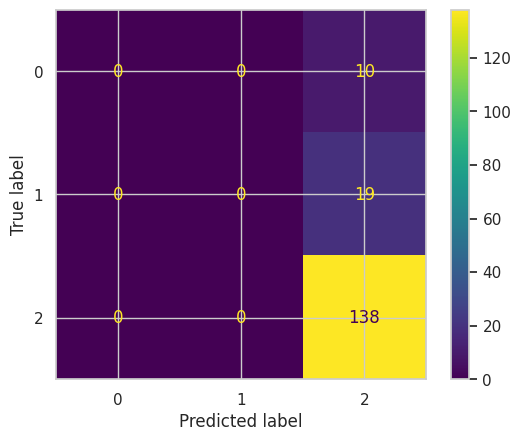

In [184]:
pred_rfc = rscv.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, pred_rfc)).plot()

In [185]:
print(classification_report(y_test, pred_rfc, zero_division=0))

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        10
Bluish-Green       0.00      0.00      0.00        19
       Green       0.83      1.00      0.90       138

    accuracy                           0.83       167
   macro avg       0.28      0.33      0.30       167
weighted avg       0.68      0.83      0.75       167



### Validacion Cruzada

Notamos que la evolucion de las metricas de validacion en los conjuntos de validacion cruzada tambien son las mismas.

In [192]:
# Separamos las características y la variable objetivo
X = coffee.drop('Color', axis=1)
y = coffee['Color']

# Creamos el modelo SVM
modelo_sub = RandomForestClassifier(n_estimators= 376, max_depth=5)

# Creamos el objeto de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar los resultados de cada iteración
precisiones = []
exhaustividades = []
exactitudes = []

# Bucle para realizar la validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenamos el modelo
    modelo_sub.fit(X_train, y_train)

    # Realizamos las predicciones
    y_pred = modelo_sub.predict(X_test)

    # Calculamos las métricas y las añadimos a las listas
    precisiones.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    exhaustividades.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
    exactitudes.append(accuracy_score(y_test, y_pred))

# Calculamos la media de las métricas
precision_media = np.mean(precisiones)
exhaustividad_media = np.mean(exhaustividades)
exactitud_media = np.mean(exactitudes)

print(f'Precisión media: {precision_media}')
print(f'Exhaustividad media: {exhaustividad_media}')
print(f'Exactitud media: {exactitud_media}')


Precisión media: 0.2717697135848784
Exhaustividad media: 0.332824427480916
Exactitud media: 0.8143712574850299


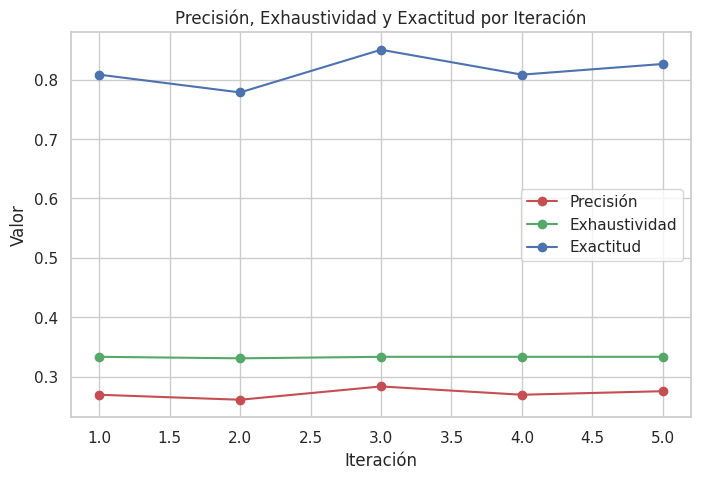

In [193]:
# Creamos el eje x para el gráfico
eje_x = range(1, len(precisiones) + 1)

plt.figure(figsize=(8, 5))

# Graficamos las precisiones
plt.plot(eje_x, precisiones, marker='o', linestyle='-', color='r', label='Precisión')

# Graficamos las exhaustividades
plt.plot(eje_x, exhaustividades, marker='o', linestyle='-', color='g', label='Exhaustividad')

# Graficamos las exactitudes
plt.plot(eje_x, exactitudes, marker='o', linestyle='-', color='b', label='Exactitud')

plt.xlabel('Iteración')
plt.ylabel('Valor')
plt.title('Precisión, Exhaustividad y Exactitud por Iteración')
plt.legend()

plt.show()

### Visualizacion de clasificaion


Nuevamente visualizamos solo con dos dimenciones de los datos como trabaja la clasificacion este algoritmo de bosques de decision, y notamos cierta diferencia con el metodo anterior.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



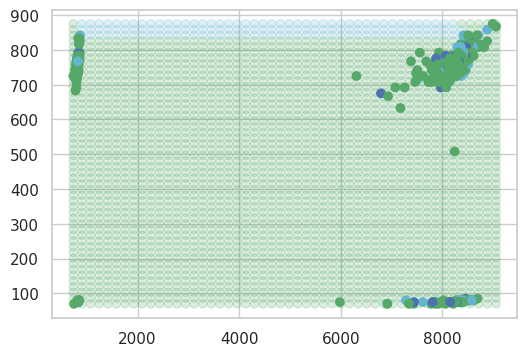

In [186]:
modelo_sub = RandomForestClassifier(n_estimators= 376, max_depth=5)
X_train_subset = X_train[['Scores_Total', 'Scores_Aroma']]

# Ajusta el modelo con el subconjunto de datos
modelo_sub.fit(X_train_subset, y_train)

x = np.linspace(np.min(X_train_subset['Scores_Total']), np.max(X_train_subset['Scores_Total']), 50)
y = np.linspace(np.min(X_train_subset['Scores_Aroma']), np.max(X_train_subset['Scores_Aroma']), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

pred_grid = pd.Series(modelo_sub.predict(grid))

fig, ax = plt.subplots(figsize=(6,4))
colores = {'Green':'g', 'Blue-Green':'b', 'Bluish-Green':'c'}
ax.scatter(grid[:,0], grid[:,1], c=pred_grid.map(colores), alpha = 0.2)
ax.scatter(X_train_subset['Scores_Total'], X_train_subset['Scores_Aroma'], c=y_train.map(colores), alpha = 1)

En este caso parece detectar una pequea region de la clase azul, pero no representa efectivamente las clases, al menos para estas variables.

# ***Conclusiones***

Los diferentes métodos de clasificación tanto los basados en máquinas de soporte vectorial como los basados en árboles de decisión han demostrado un rendimiento no tan excelente para el conjunto de datos de entrada, debido principalmente al gran desbalance que poseen las clases.

Pero en general, pudimos notar un mejor rendimiento en el tercer (Support Vector Machine Gaussiano) y cuarto modelo (RandomForest Classifier) en que han acertado su mayoría las predicciones debido a que predecían generalmente la clase mayoritaria. Por lo que resultaban modelo sesgados. Al modelo de clasificación de Support vector machines con kernel lineal no le ocurría este sesgo debido a su balance en los pesos del modelo, pero sí demostró equivocarse mucho más en sus estimaciones, teniendo a clasificaciones que resultan incorrectas.

Por lo que si tuviéramos que escoger un modelo de los tres propuestos para esta tarea específica con estos datos, sería cualquiera de los últimos dos debido a que su rendimiento es prácticamente el mismo en ambos.
